### ../src/fcSelector.py

2022-06-08 22:42:18 INFO     evaluating model time of week temperature
2022-06-08 22:42:18 INFO     evaluating model extra trees pipeline
2022-06-08 22:42:18 INFO     evaluating model random forest pipeline
2022-06-08 22:42:18 INFO     evaluating model multi layer perceptron
2022-06-08 22:42:18 INFO     evaluating model tuned mlp
2022-06-08 22:42:18 INFO     evaluating model tuned-Total mlp
2022-06-08 22:42:19 INFO     evaluating model tuned-Fast mlp
2022-06-08 22:42:19 INFO     evaluating model random forest
2022-06-08 22:42:19 INFO     evaluating model extra trees
2022-06-08 22:42:19 INFO     evaluating model sarimax
2022-06-08 22:42:20 INFO     evaluating model time of day temperature


Loop runtime: 2.3247 seconds
best forecaster: time of week temperature
score: -0.8404303812213878
                                                model     score  score_adj  \
0                          time_of_week_temperature() -0.840430  -1.453907   
10  <fcLib.time_of_day_temperature object at 0x7fa... -2.985822  -4.314430   
4                                      mlpregressor() -3.082183  -4.442911   
8                                        extratrees() -3.165578  -4.554105   
9      <fcLib.stats_sarimax object at 0x7fa6be2bafa0> -3.274199  -4.698932   
1                                extratreespipeline() -3.294740  -4.726319   
6                                      mlpregressor() -3.314931  -4.753241   
5                                      mlpregressor() -3.347503  -4.796670   
2                              randomforestpipeline() -3.537257  -5.049675   
7                                      randomforest() -4.765749  -6.687665   
3                                      mlpre

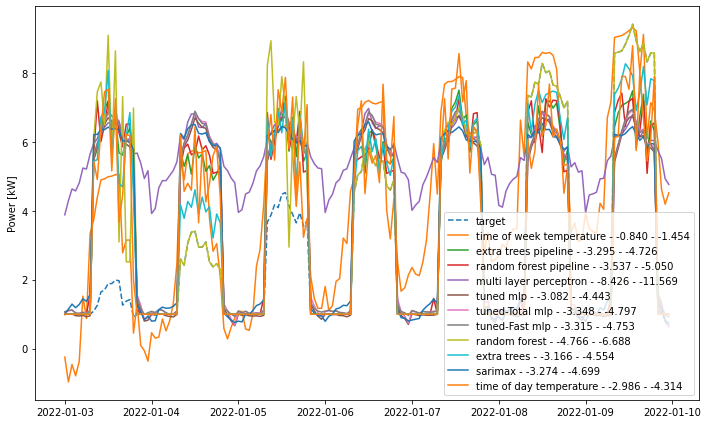

FIXME: EVAL of Sarima (and others)


In [1]:
import os
import sys
import time
import json
import logging
import pandas as pd
import numpy as np
import concurrent.futures
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')
try:
    root = os.path.dirname(os.path.abspath(__file__))
except:
    root = os.getcwd()

# Append src directory to import forecaster library files
sys.path.append(os.path.join(root, '..', 'src'))
import fcLib

default_params = {'train_size': 0.75, 'train_method': 'train_test_split'}

def adjust_r2(r2, n, p):
    return 1-(1-r2)*(n-1)/(n-p-1)

class ForecasterFramework():
    '''
    This class provides a framework for defining, training and
    evaluating a list of forecaster models (as defined in the)
    fcLib.py module.
    
    methods:
    __init__: Initializes the framework with a list of models to 
              evaulate, and a training dataset to use for model
              training and testing.
    updateData: allows users to pass new training data, which is
              split into X and y datasets
    updateForecasters: allows user to update list of forecast models
              and parameters for use in evaluation.
    evaluateAllLoop: method to train/test all models using simple loop
    evaluateAll: method to train/test all models using multi-processing
    selectFc: method to select best-performing forecast model based on
              results of evaluation
    scoreSummary: provides summary of each model performance
    plotPredictions: generates a plot of each model for testing horizon
    
              
    '''
    
    def __init__(self, params={}, data=None, fcList=[]):
        '''
        Initializes the framework with a list of models to 
        evaulate, and a training dataset to use for model
        training and testing.
        
        inputs:
        fcList: list of dicts defining forecaster models
            to evaluation. Dicts contain keys:
            
            fun: name of forecast model to evaluate, 
            corresponding to model types defined in fcLib
            
            name: (optional) sting with name of forecast model
            being used. Necessary if passing multiple forecasters
            of same type with different parameters. Default name
            set to 'fun' name. If multple forecasters of same type
            passed, the 'name' will be auto incrememted
            
            parameters: parameters to tune each model.
        data: dict with X and y items, corresponding to features
            and target values. X should be pandas df, y numpy array

        '''
        
        self.params = params
        self.fcList = fcList
        self.fcData = None
        self.bestModel = None
        self.validData = False
        
        # parse parameter
        k = self.params.keys()
        self.train_size = self.params['train_size'] if 'train_size' in k else 0.75
        self.train_method = self.params['train_method'] if 'train_method' in k else 'train_test_split'
        self.min_days = self.params['min_days'] if 'min_days' in k else 14
        
        self.updateData(data)
        
        
        
    def updateData(self, data):
        # method sets data
        self.data = data
        self.X = None
        self.y = None
        
        assert len(data['X']) == len(data['y']), "Length of data differs."
        if data['X'].index[0] + pd.DateOffset(days=self.min_days) > data['X'].index[-1]:
            logging.warning(f'Data horizon is too short.')
        else:
            self.validData = True
        self.X = data['X']
        self.y = data['y']
        
    def updateForecasters(self, fcList):
        
        self.fcList = fcList
        
        
    def evaluate(self, model, X=None, y=None, random_state=None, train_size=0.75, train_method='train_test_split',
                 X_train=None, X_test=None, y_train=None, y_test=None):
        '''
        This method evaluates the model's ability to match a data set and returns
        the resulting r^2 value. It uses existing scikit-learn functions to do so.
        
        Inputs:
        X_train: Training subset of the input data.
        X_test: Testing subset of the input data.
        y_train: Training subset of the output data.
        y_test: Testing subset of the output data.
        
        Outputs:
        Returns the r^2 value evaluating the model's ability to fit the test
            data set.
        '''
        msg = ''
        if X is None or y is None:
            # if full data is not provided, ensure train/test data is passed as input
            assert X_train is not None, "training data must be provided if full data is missing"
            assert y_train is not None, "training data must be provided if full data is missing"
            assert X_test is not None, "testing data must be provided if full data is missing"
            assert y_test is not None, "testing data must be provided if full data is missing"
            # use testing dataset for evaluation prediction
            X_predict = X_test
        else:
            # else, use train_test_split to generate split datasets
            if len(y) > 1:
                if train_method == 'train_test_split':
                    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size,
                                                                        random_state=random_state)
                if train_method == 'daily_split':
                    X_date = np.unique(X.index.date)
                    y_date = np.unique(y.index.date)
                    X_train, X_test, y_train, y_test = train_test_split(X_date, y_date, train_size=train_size,
                                                                        random_state=random_state)
                    X_train = X[np.isin(X.index.date, X_train)]
                    X_test = X.loc[np.isin(X.index.date, X_test)]
                    y_train = y.loc[np.isin(y.index.date, y_train)]
                    y_test = y.loc[np.isin(y.index.date, y_test)]
                    
            # use full X dataset for evaluation prediction
            X_predict = X
        
        # create fitted model, score, and prediction
        st = time.time()
        default_output = False
        if len(np.unique(y.index.date)) > 5:
            try:
                model.fit(X_train, y_train)
                score = model.score(X_test, y_test) 
                prediction = model.predict(X)
                mse = mean_squared_error(y_test, model.predict(X_test))
                p = 1 if type(y_train)==type(pd.Series(dtype=int)) else len(y_train.columns)
                n = len(np.unique(y_train.index.date))
            except Exception as e:
                msg = f'ERROR: {model}\n{e}'
                default_output = True
        else:
            default_output = True
            
        if default_output:
            self.validData = False
            score = -1
            prediction = []
            mse = -1
            p = 1
            n = 1
            
        res = {'model': model,
               'score': score if self.validData else -1,
               'score_adj': adjust_r2(score, n, p) if self.validData else -1,
               'score_mse': mse if self.validData else -1,
               'score_rmse': np.sqrt(mse) if self.validData else -1,
               'x-cols': json.dumps(list(X.columns)),
               'y-cols': json.dumps(y.name),
               'prediction': prediction,
               'duration': time.time() - st,
               'msg': msg}
        return res
    
        
    def evaluateAll(self, parallel=False):
        '''
        
        ''' 
        
        # initialize dict of forecaster data
        fcData = []
        predictions = []
        # initialize list of forecaster futures (for multiprocessing)
        modelFutures = {}
        
        # Optional, split data before evaluation
        #X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, train_size = 0.75)
        random_state = int(time.time())
        
        # loop through forecasters given by user
        with concurrent.futures.ProcessPoolExecutor() as executor:
            for i, fc in enumerate(self.fcList):

                # import and instantiate forecaster
                fcObj = getattr(fcLib, fc['fun'])(**fc['parameter'])

                # create run evaluate method of each forecaster as multiprocess
                logging.info(f'evaluating model {fc["name"]}')
                
                if parallel:
                    modelFutures[fc['name']] = executor.submit(self.evaluate, fcObj, self.X, self.y,
                                                               random_state, self.train_size, self.train_method)
                else:
                    st = time.time()
                    results = self.evaluate(fcObj, X=self.X, y=self.y, random_state=random_state,
                                            train_size=self.train_size, train_method=self.train_method)
                    results['name'] = fc['name']
                    predictions.append(results['prediction'])
                    del results['prediction']
                    fcData.append(results)
        if parallel:
            for i, fc in enumerate(self.fcList):
                results = modelFutures[fc['name']].result()
                results['name'] = fc['name']
                predictions.append(results['prediction'])
                del results['prediction']
                fcData.append(results)
        
        self.fcData = pd.DataFrame(fcData)
        self.predictions = predictions
        
        self.selectFc()
    
    def selectFc(self):
        best = self.fcData.sort_values('score').iloc[-1]
        self.bestModel = best['model']
        self.bestScore = best['score']
        self.bestModelName = best['name']
    
    def predict(self, X):
        assert self.bestModel is not None, 'Forecaster models must be fit before prediction.'
        return self.bestModel.predict(X)            
    
    def plotPredictions(self):
        
        assert self.fcData is not None, 'Forecaster models must be fit before plotting'
        
        plt.figure(figsize = (10, 6))
        plt.plot(self.y.index, self.y, label = 'target', linestyle = 'dashed')
        
        for ix, fcResults in self.fcData.iterrows():
            fcLabel = f'{fcResults["name"]} - {fcResults["score"]:0.3f} - {fcResults["score_adj"]:0.3f}'
            plt.plot(self.y.index, self.predictions[ix], label = fcLabel)
        plt.legend()
        
        plt.ylabel(self.y.name)
        plt.tight_layout()
        plt.show()
        
if __name__ == '__main__':
    cwd = os.getcwd()
    file = '../resources/data/sample_data.csv'
    path = os.path.join(cwd, file)
    
    params = default_params.copy()
    params['train_method'] = 'daily_split'
    params['min_days'] = 6

    data = pd.read_csv(path)
    data.index = pd.date_range('2022-01-03', '2022-01-09 23:00', freq='1H')
    data = data.rename(columns={'TDryBul (deg C)': 'OAT [C]', 'Power (kW)': 'Power [kW]', 'Time of Week (hr)': 'ToW [h]'})
    data['OCC [1]'] = np.where(data['Power [kW]'] == 1, 0, 1)
    data['hour'] = data.index.hour

    # package data for framework
    data_eval = {
        'X': data[['OAT [C]', 'OCC [1]', 'hour']],
        'y': data['Power [kW]']
    }

    fcList = fcLib.forecasters

    fcList[0]['parameter']['temp_col'] = 'OAT [C]'
    fcList[10]['parameter']['oat_col'] = 'OAT [C]'

    a = ForecasterFramework(params=params, data=data_eval, fcList=fcList)

#     startTime = time.perf_counter()
#     a.evaluateAll(parallel=True)
#     endTime = time.perf_counter()
#     print(f'Multiprocess runtime: {endTime - startTime:0.4f} seconds.')

    startTime = time.perf_counter()
    a.evaluateAll(parallel=False)
    endTime = time.perf_counter()
    print(f'Loop runtime: {endTime - startTime:0.4f} seconds')
    print(f'best forecaster: {a.bestModelName}')
    print(f'score: {a.bestScore}')

    print(a.fcData.sort_values('score', ascending=False))
    
    try:
        a.plotPredictions()
    except:
        pass
    
    print('FIXME: EVAL of Sarima (and others)')